In [1]:
using SSM
using Random
using Distributions
using Plots
using LinearAlgebra
using CSV
using DataFrames

In [2]:
include("/Users/ryansenne/Documents/Github/ssm_julia//src/SSM.jl")
# include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using Random
using .SSM
using Distributions
using Plots
using LinearAlgebra
using ForwardDiff
using StatsFuns
using Optim

18667×1 Matrix{Float64}:
 -10.0
  20.0
  -6.0
  -3.0
   4.0
   4.0
  -2.0
   5.0
   5.0
 -10.0
   ⋮
  -4.0
   4.0
  -2.0
   3.0
   6.0
   2.0
  -6.0
  -5.0
  -6.0

In [42]:
# generate some data from a PPCA model
z = randn(1000, 2)
W = randn(3, 2)

data = z * W' + randn(1000, 3)

ppca = ProbabilisticPCA(K=2, D=3)


ll = SSM.fit!(ppca, data)

53-element Vector{Any}:
   -Inf
 -5898.449080653427
 -5749.78045879042
 -5681.058062511805
 -5653.788714722393
 -5642.036691771223
 -5634.561313809445
 -5627.9270722463925
 -5621.371733294797
 -5615.076081672076
     ⋮
 -5593.854133818283
 -5593.8541380824645
 -5593.854141480669
 -5593.854144172893
 -5593.8541462966305
 -5593.854147966679
 -5593.854149277038
 -5593.854150303605
 -5593.854151107059

In [46]:
W

3×2 Matrix{Float64}:
 -0.490389  -0.887624
  1.83141   -0.267726
  1.92931   -0.0535091

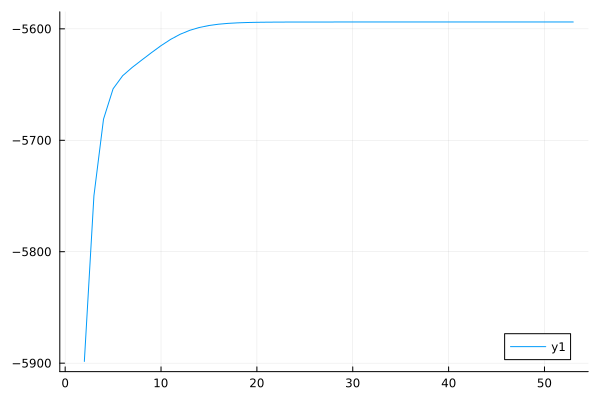

In [43]:
plot(ll)

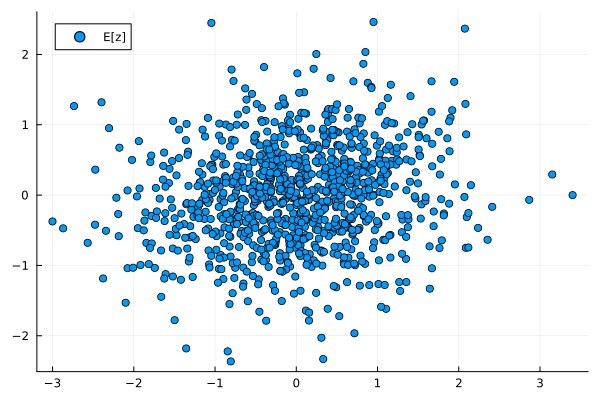

In [44]:
scatter(ppca.z[:, 1], ppca.z[:, 2], label="E[z]", legend=:topleft)

In [47]:
ppca.σ²

0.9735059823264552

In [ ]:
# generate synthetic data
Random.seed!(123)

X = randn(length(choice), 1)
X = [ones(length(choice)) X]

β = [1.0, 2.0]
μ = X * β

y = rand.(Poisson.(exp.(μ)))

# create a PoissonRegression model
model = PoissonRegression(include_intercept = false)
model.β = zeros(2)
# fit the model
fit!(model, X, y)

In [ ]:
using ForwardDiff
# create an objective function to look at the grad of the loglikelihood
obj = β -> -SSM.loglikelihood(PoissonRegression(β, false, 0.0), X, y)

grad = ForwardDiff.gradient(obj, [0.0, 0.0])


In [ ]:
# synthetic poisson regression data
Random.seed!(123)

# set parameters
n = 100
β = [0.1, 0.9]
# generate data

X = hcat(ones(n), randn(n, 1))
λ = exp.(X * β)

y = rand.(Poisson.(λ))

poisreg = SSM.PoissonRegression()
SSM.fit!(poisreg, reshape(X[:, 2], length(y), 1), y)

In [ ]:
model = SSM.SwitchingPoissonRegression(;K=2, λ=0.1)
fit!(model, reshape(X[:, 2], length(y), 1), y)

In [ ]:
# Parameters
n = 1000
β₁ = [0.1, 0.9]
β₂ = [0.9, 0.1]
σ²₁ = 0.1
σ²₂ = 0.1
A = [0.9 0.1; 0.1 0.9]

# Data generation
X = hcat(ones(n), randn(n, 1))
y = zeros(n)
state = Vector{Int}(undef, n)

for i in 1:n
    if i == 1
        # choose a state at random
        state[i] = rand(1:2)
    else
        # Transition based on previous state
        state[i] = rand(Categorical(A[state[i-1], :]))
    end

    if state[i] == 1
        y[i] = X[i, :]' * β₁ + sqrt(σ²₁) * randn()
    else
        y[i] = X[i, :]' * β₂ + sqrt(σ²₂) * randn()
    end
end

# Fit linear regression model
linreg = SSM.SwitchingGaussianRegression(; K=2, λ=0.1)
SSM.fit!(linreg, reshape(X[:, 2], length(y), 1), y, 10000, 1e-6)

println("Fitted coefficients: ", linreg.B[1].regression.β)


In [ ]:
γ, ξ, α, β = SSM.E_step(linreg, reshape(X[:, 2], length(y), 1), y)

In [ ]:
plot(state.-1)
plot!(exp.(γ[:, 1]))

In [3]:
using Distributions
using LinearAlgebra

function simulate_LDS(T::Int, α::Float64, β::Float64, x₀::Vector{Float64}, Q::Matrix{Float64}, R::Float64)
    # pre-allocate array
    state = zeros(T, 2) # pos/velocity
    observation = zeros(T, 1) # observations
    observation[1] = x₀[1]
    # set up parameters
    A = [1 1; -β (1-α)]
    state[1, :] = x₀
    process_noise = MvNormal(zeros(2), Q)
    observation_noise = Normal(0, R)
    # simulate
    for t in 2:T
        state[t, :] = A * state[t-1, :] .+ rand(process_noise)
        observation[t, :] = state[t] .+ rand(observation_noise, 1)
    end
    return state, observation
end

# simulate 10 steps of this model
state_sequence, observation_sequence = simulate_LDS(4, 0.9, 0.75, [1., -1], [0.01 0; 0 0.01], 1.)

# set up parameters, we currently are assuming we know these, in practice we may know only a few, if any at all
β = 0.75
α = 0.9
A = [1 1; -β (1 - α)]
H = reshape([1., 0.], 1, 2)
Q = 0.01 * I(2)
R = [1.;;]
x₀ = [1, -1]
P₀ = 0.01 * I(2)

# set up a LDS object
spring_LDS = SSM.LDS(;A=A, H=H, Q=Q, R=R, x0=x₀, p0=P₀, obs_dim=1, latent_dim=2, fit_bool=fill(false, 7))


hessian, main, super, sub = SSM.Hessian(spring_LDS, observation_sequence)

(sparse([1, 2, 3, 4, 1, 2, 3, 4, 1, 2  …  7, 8, 5, 6, 7, 8, 5, 6, 7, 8], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8], [-257.25, -92.5, 100.0, -75.0, -92.5, -201.0, 100.0, 9.999999999999998, 100.0, 100.0  …  100.0, 9.999999999999998, 100.0, 100.0, -101.0, 0.0, -75.0, 9.999999999999998, 0.0, -100.0], 8, 8), [[-257.25 -92.5; -92.5 -201.0], [-257.25 -92.5; -92.5 -201.0], [-257.25 -92.5; -92.5 -201.0], [-101.0 0.0; 0.0 -100.0]], [[100.0 -75.0; 100.0 9.999999999999998], [100.0 -75.0; 100.0 9.999999999999998], [100.0 -75.0; 100.0 9.999999999999998]], [[100.0 100.0; -75.0 9.999999999999998], [100.0 100.0; -75.0 9.999999999999998], [100.0 100.0; -75.0 9.999999999999998]])